In [1]:
from config import DATASET_PATH, DATASET_URL
from data_handling import DataHandler
from model.feature_engineering.FeatureEngineeringFunction import add_previous_count_hour
from model.feature_engineering.FeatureEngineeringFunction import add_previous_count_geo
from model.feature_engineering.FeatureEngineeringFunction import add_previous_count_timestamp
from model.feature_engineering.FeatureEngineeringFunction import add_statistic_features
from model.feature_engineering.FeatureEngineeringFunction import add_time_index
from model.feature_engineering.FeatureEngineeringFunction import add_previous_hour_demand_by_geo
from model.feature_engineering.FeatureEngineeringFunction import add_previous_day_demand_by_geo

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
import warnings
import os
import geohash
import matplotlib.pyplot as plt
import pickle
import time
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def load_dataframe():
    data_handler = DataHandler()
    data_handler.download_dataset(DATASET_URL, DATASET_PATH)
    data_handler.extract_file(data_handler.file_name, 
                          data_handler.file_path, 
                          data_handler.folder_path)
    FULL_PATH = DATASET_PATH + "Traffic Management/training.csv"
    
    print(FULL_PATH)
    
    return data_handler.load_dataset(FULL_PATH)

# Exploratory Data Analysis

In [3]:
df = load_dataframe()
# df = df[df['day'] < 5]

Checking if path exist
File has been downloaded!
Done! Here are the extracted files/ folders
Traffic Management
./data/traffic_management/Traffic Management/training.csv


## Examing count for each feature

First we generate count features. These feature are based on the total number of a specific feature from the original dataset (the count of the current geohash6 on the previous day, the total instants on the previous hour, ...)

Below is the basic function for generate this kind of feature, which generate lag of 7 previous day and rolling statistic with step 1 and window size of 4

(If there were more time, i'd love to example these feature more carefully)

In [6]:
def add_additional_statistic_feature(df, raw_feature_name):
    if raw_feature_name == "day_over_hour":
        df = add_previous_count_hour(df, lag_num=1)
        df = add_previous_count_hour(df, lag_num=2)
        df = add_previous_count_hour(df, lag_num=3)
        df = add_previous_count_hour(df, lag_num=4)
        df = add_previous_count_hour(df, lag_num=5)
        df = add_previous_count_hour(df, lag_num=6)
        df = add_previous_count_hour(df, lag_num=7)
    
    elif raw_feature_name == "day_over_geo":
        df = add_previous_count_geo(df, lag_num=1)
        df = add_previous_count_geo(df, lag_num=2)
        df = add_previous_count_geo(df, lag_num=3)
        df = add_previous_count_geo(df, lag_num=4)
        df = add_previous_count_geo(df, lag_num=5)
        df = add_previous_count_geo(df, lag_num=6)
        df = add_previous_count_geo(df, lag_num=7)

    elif raw_feature_name == "day_over_timestamp":
        df = add_previous_count_timestamp(df, lag_num=1)
        df = add_previous_count_timestamp(df, lag_num=2)
        df = add_previous_count_timestamp(df, lag_num=3)
        df = add_previous_count_timestamp(df, lag_num=4)
        df = add_previous_count_timestamp(df, lag_num=5)
        df = add_previous_count_timestamp(df, lag_num=6)
        df = add_previous_count_timestamp(df, lag_num=7)

    for i in range(1, 4):
        df = add_statistic_features(df, raw_feature_name=raw_feature_name, 
                                                             start_time=i, 
                                                             time_range=4)
        return df

In [23]:
def check_effect_count(df, feature_name):
    check_df = df # This is a holder dataframe
    
    # Create input and label 
    y = check_df['demand'].values
    
    df_without_demand = check_df.drop(columns=['demand'])
    X = df_without_demand.values
    
    
    
    # Create LGBM model
    evaluator = LGBMRegressor()
    evaluator.fit(X, y)
    y_hat = evaluator.predict(X)
    print("Current MSE: " + str(mean_squared_error(y, y_hat)))
    # Get and plot importance
    importance = evaluator.feature_importances_
    columns = list(df_without_demand.columns)
    importance, columns = zip(*sorted(zip(importance, columns),reverse=True)) # Sort decreasing
    trace = go.Bar(x=columns, y=importance)
#     trace2 = go.Bar(x=columns, )
    data = [trace]
    layout = go.Layout(
        title=go.layout.Title(
            text= feature_name + ' importance',
            xref='paper',
            x=0
        ),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
                text='Feature name',
                font=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f'
                )
            )
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
                text='Importance',
                font=dict(
                    family='Courier New, monospace',
                    size=18,
                    color='#7f7f7f'
                )
            )
        )
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    evaluator = None
    rfe = RFE(LGBMRegressor())
    fit = rfe.fit(X, y)
#     evaluator.fit(X, y)
    list_of_columns = list(df_without_demand.columns)
    support = fit.support_
    compare_df = pd.DataFrame({"columns":list_of_columns, 'worth':support})
    
    print("RLE result for checking best features: ")
    print(compare_df)
    selected_feature = compare_df[compare_df['worth'] == True]['columns'].values.tolist()
    return selected_feature
#     print(fit.support_)

To select the best feature for each model, we visualize the importance of each feature with LGBM, then check again with RFE (which we set default to 5 best feature). After visualizing, the best features are written to disk (due to the limit of my computer).

### Count by hour

In [6]:
df = add_additional_statistic_feature(df, "day_over_hour")

In [7]:
df[:10]

,geohash6,day,timestamp,demand,hour,day_over_hour_1,day_over_hour_2,day_over_hour_3,day_over_hour_4,day_over_hour_5,day_over_hour_6,day_over_hour_7,day_over_hour_mean_w_1_5,day_over_hour_min_w_1_5,day_over_hour_max_w_1_5
0,qp03wc,18,20:0,0.020072,20,1299,1248,1179,1198,1116,1149,1336,1208.0,1116,1299
1,qp03pn,10,14:30,0.024721,14,2697,2920,2864,2790,2926,3156,2857,2839.4,2697,2926
2,qp09sw,9,6:15,0.102821,6,3766,3673,3470,3653,3807,3637,3674,3673.8,3470,3807
3,qp0991,32,5:0,0.088755,5,3644,3545,3424,3664,3328,3619,3751,3521.0,3328,3664
4,qp090q,15,4:0,0.074468,4,3645,3460,3549,3587,3396,3547,3804,3527.4,3396,3645
5,qp03tu,1,12:15,0.023843,12,0,0,0,0,0,0,0,0.0,0,0
6,qp096d,25,3:30,0.007460,3,3479,3496,3450,3454,3209,3458,3697,3417.6,3209,3496
7,qp03nr,51,20:45,0.000293,20,1249,1206,1418,1190,1400,1631,1323,1292.6,1190,1418
8,qp093r,48,6:15,0.054170,6,3692,3835,3840,3894,3879,3881,3640,3828.0,3692,3894
9,qp03r2,4,22:15,0.123463,22,2423,2406,2683,0,0,0,0,1502.4,0,2683


In [8]:
df = df.drop(columns=['geohash6', 'day', 'timestamp', 'hour'])

#### Evaluate importance with LGBM and RFE

In [47]:
best_features = check_effect_count(df, "day_over_hour")

Current MSE: 0.024494417810371778


RLE result for checking best features: 
                    columns  worth
0           day_over_hour_1   True
1           day_over_hour_2  False
2           day_over_hour_3  False
3           day_over_hour_4  False
4           day_over_hour_5  False
5           day_over_hour_6   True
6           day_over_hour_7   True
7  day_over_hour_mean_w_1_5  False
8   day_over_hour_min_w_1_5   True
9   day_over_hour_max_w_1_5   True


In [45]:
day_over_hour = df[best_features]
day_over_hour.to_csv("day_over_hour.csv")

### Count by geo

In [6]:
df = load_dataframe()
df = add_additional_statistic_feature(df, "day_over_geo")

Checking if path exist
File has been downloaded!
Done! Here are the extracted files/ folders
Traffic Management
./data/traffic_management/Traffic Management/training.csv


In [7]:
df[:10]

,geohash6,day,timestamp,demand,day_over_geo_1,day_over_geo_2,day_over_geo_3,day_over_geo_4,day_over_geo_5,day_over_geo_6,day_over_geo_7,day_over_geo_mean_w_1_5,day_over_geo_min_w_1_5,day_over_geo_max_w_1_5
0,qp03wc,18,20:0,0.020072,96,96,96,94,93,96,96,95.0,93,96
1,qp03pn,10,14:30,0.024721,71,71,71,65,61,67,71,67.8,61,71
2,qp09sw,9,6:15,0.102821,91,91,83,82,91,91,96,87.6,82,91
3,qp0991,32,5:0,0.088755,84,82,84,81,75,87,76,81.2,75,84
4,qp090q,15,4:0,0.074468,81,64,77,76,69,73,76,73.4,64,81
5,qp03tu,1,12:15,0.023843,0,0,0,0,0,0,0,0.0,0,0
6,qp096d,25,3:30,0.007460,45,52,42,44,35,35,37,43.6,35,52
7,qp03nr,51,20:45,0.000293,85,87,85,80,88,92,92,85.0,80,88
8,qp093r,48,6:15,0.054170,82,82,88,88,86,86,81,85.2,82,88
9,qp03r2,4,22:15,0.123463,96,96,96,0,0,0,0,57.6,0,96


In [9]:
df = df.drop(columns=['geohash6', 'day', 'timestamp'])

#### Evaluate with LGBM and RFE

In [10]:
best_features = check_effect_count(df, "day_over_geo")

Current MSE: 0.016119975315116122


RLE result for checking best features: 
                   columns  worth
0           day_over_geo_1   True
1           day_over_geo_2  False
2           day_over_geo_3  False
3           day_over_geo_4  False
4           day_over_geo_5  False
5           day_over_geo_6   True
6           day_over_geo_7   True
7  day_over_geo_mean_w_1_5   True
8   day_over_geo_min_w_1_5   True
9   day_over_geo_max_w_1_5  False


In [12]:
day_over_geo = df[best_features]
day_over_geo.to_csv("day_over_geo.csv")

### Count by timestamp

In [14]:
df = load_dataframe()
df = add_additional_statistic_feature(df, "day_over_timestamp")

Checking if path exist
File has been downloaded!
Done! Here are the extracted files/ folders
Traffic Management
./data/traffic_management/Traffic Management/training.csv


In [15]:
df[:10]

,geohash6,day,timestamp,demand,day_over_timestamp_1,day_over_timestamp_2,day_over_timestamp_3,day_over_timestamp_4,day_over_timestamp_5,day_over_timestamp_6,day_over_timestamp_7,day_over_timestamp_mean_w_1_5,day_over_timestamp_min_w_1_5,day_over_timestamp_max_w_1_5
0,qp03wc,18,20:0,0.020072,300,279,265,275,271,288,330,278.0,265,300
1,qp03pn,10,14:30,0.024721,672,717,702,682,703,767,723,695.2,672,717
2,qp09sw,9,6:15,0.102821,939,931,872,921,945,913,920,921.6,872,945
3,qp0991,32,5:0,0.088755,914,893,852,919,858,931,944,887.2,852,919
4,qp090q,15,4:0,0.074468,912,860,892,881,838,892,954,876.6,838,912
5,qp03tu,1,12:15,0.023843,0,0,0,0,0,0,0,0.0,0,0
6,qp096d,25,3:30,0.007460,890,876,861,863,807,859,920,859.4,807,890
7,qp03nr,51,20:45,0.000293,338,311,380,302,336,412,362,333.4,302,380
8,qp093r,48,6:15,0.054170,921,959,972,970,958,976,907,956.0,921,972
9,qp03r2,4,22:15,0.123463,562,557,638,0,0,0,0,351.4,0,638


In [16]:
df = df.drop(columns=['geohash6', 'day', 'timestamp'])

#### Evaluate with LGBM and RFE

In [17]:
best_features = check_effect_count(df, "day_over_timestamp")

Current MSE: 0.024534394278956


RLE result for checking best features: 
                         columns  worth
0           day_over_timestamp_1   True
1           day_over_timestamp_2  False
2           day_over_timestamp_3   True
3           day_over_timestamp_4  False
4           day_over_timestamp_5  False
5           day_over_timestamp_6   True
6           day_over_timestamp_7   True
7  day_over_timestamp_mean_w_1_5  False
8   day_over_timestamp_min_w_1_5   True
9   day_over_timestamp_max_w_1_5  False


In [18]:
day_over_geo = df[best_features]
day_over_geo.to_csv("day_over_timestamp.csv")

Some points:

    * Overall, the count of geo seem to produce better result
    * Most of the best features gather around 5, so we don't change it in the function (if the visualization show drastic change, we can modify this value specifically)

## Examing by demand

In [4]:
df = add_previous_hour_demand(df, lag_hour=1)

In [6]:
group_by_index = df.sort_values("time_index").groupby("time_index")
list_of_series = []
for group in group_by_index:
    list_of_series.append(group[1]['geo_demand_hour_1'].sum())

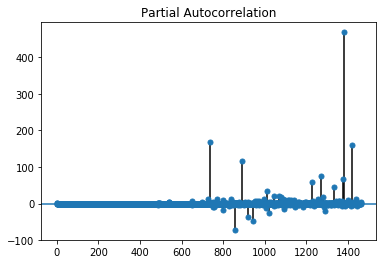

In [10]:
plot_pacf(list_of_series)
plt.show()

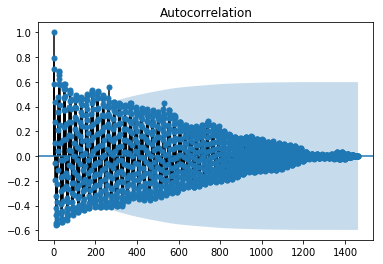

In [11]:
plot_acf(list_of_series)
plt.show()

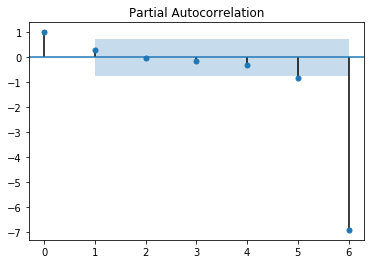

In [24]:
plot_pacf(list_of_series[:7])
plt.show()

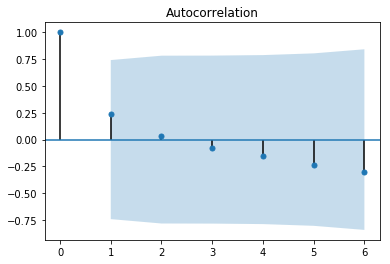

In [25]:
plot_acf(list_of_series[:7])
plt.show()

From the first pacf plot, we can see a lot of value passing the 1 and -1 threshold, therefore we reduce the lag down to 7 (days of week) to check, and the result show that lag of 1 - 5 is better.

By acf plot of the first 7 lag show little coorelation between the lag from 1-5 (however 5 and 1 seem to be better). Nevertheless, we still gonna use the lag of 1-5 for our evaluation

### Exam demand of day

In [9]:
df = add_previous_day_demand_by_geo(df, lag_day=1)

In [10]:
group_by_index = df.sort_values("day").groupby("day")
list_of_series = []
for group in group_by_index:
    list_of_series.append(group[1]['geo_demand_day_1'].sum())

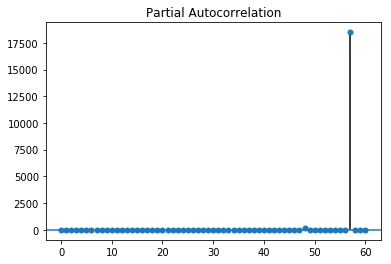

In [11]:
plot_pacf(list_of_series)
plt.show()

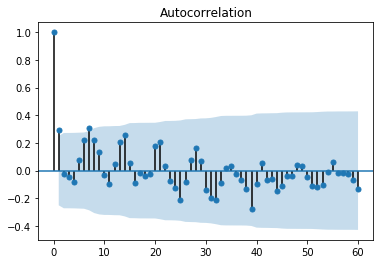

In [12]:
plot_acf(list_of_series)
plt.show()

Here we can see the pattern repeat, so selecting value day lag of 9 is justified

However, we still need to inspect pacf more carefully

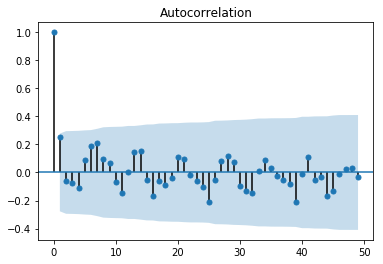

In [16]:
plot_acf(list_of_series[:50])
plt.show()

At 50 lag we still can't detect any sufficient coorelation. We have to use the same method as count and evaluate the effect of each lag on the result

In [20]:
def add_additional_statistic_feature_day_geo(df, raw_feature_name):
#     if raw_feature_name == "day_over_hour":
    df = add_previous_day_demand_by_geo(df, lag_day=1)
    df = add_previous_day_demand_by_geo(df, lag_day=2)
    df = add_previous_day_demand_by_geo(df, lag_day=3)
    df = add_previous_day_demand_by_geo(df, lag_day=4)
    df = add_previous_day_demand_by_geo(df, lag_day=5)
    df = add_previous_day_demand_by_geo(df, lag_day=6)
    df = add_previous_day_demand_by_geo(df, lag_day=7)
    df = add_previous_day_demand_by_geo(df, lag_day=8)
    df = add_previous_day_demand_by_geo(df, lag_day=9)

    
    for i in range(1, 4):
        df = add_statistic_features(df, raw_feature_name=raw_feature_name, 
                                                             start_time=i, 
                                                             time_range=5)
        return df

In [21]:
df = add_additional_statistic_feature_day_geo(df, "geo_demand_day")

In [22]:
df = df.drop(columns=['geohash6', 'day', 'timestamp'])

In [24]:
selected_feature = check_effect_count(df, "geo_demand_day")

Current MSE: 0.008853904812029278


RLE result for checking best features: 
                      columns  worth
0            geo_demand_day_1   True
1            geo_demand_day_2   True
2            geo_demand_day_3   True
3            geo_demand_day_4   True
4            geo_demand_day_5   True
5            geo_demand_day_6  False
6            geo_demand_day_7   True
7            geo_demand_day_8  False
8            geo_demand_day_9  False
9   geo_demand_day_mean_w_1_6  False
10   geo_demand_day_min_w_1_6  False
11   geo_demand_day_max_w_1_6  False


We gonna use the previous demand of day 1-5 and 7 (due to time limit)

## Geo by cluster

In [4]:
group_by_geo = df.groupby("geohash6")
x = []
y = []

for geo in group_by_geo:
    current_demand_count = geo[1]['demand'].sum()
    x.append(geo[0])
    y.append(current_demand_count)

In [5]:
coordinates = [list(geohash.decode(i)) for i in x]


In [6]:
data = np.asarray(coordinates)

In [7]:
np_y = np.asarray(y)
np_y = np_y.reshape(np_y.shape[0], 1)

In [8]:
data = np.append(data, np_y, axis=1)

In [9]:
cluster_model = KMeans(n_clusters=3)


In [10]:
cluster_model.fit(X=data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
labels = cluster_model.predict(data)

In [12]:
mapping = {0:"low", 1:"medium", 2:"high"}
labels = [mapping[i] for i in labels]

In [13]:
from sklearn.preprocessing import minmax_scale

[Text(0,0.5,'y coordinate'), Text(0.5,0,'x coordinate')]

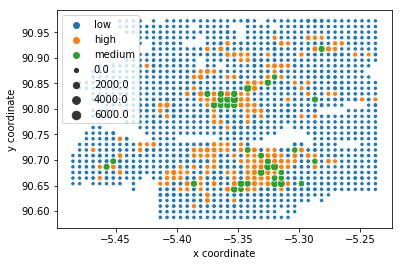

In [14]:
clustering_plot = sns.scatterplot(x=data[:,0], 
                    y = data[:,1], 
                    size=data[:,2],
                   hue=labels)
clustering_plot.set(xlabel='x coordinate', 
                    ylabel='y coordinate')

By counting demand with regard to geohash6, we can see the distibution of total traffic density over the area. This could be a useful feature for our model

In [19]:
geo_density_map = {}
for i in range(len(labels)):
    geo_density_map[x[i]] = labels[i]

In [21]:
with open("database/geo_to_density.map", "wb") as f:
    pickle.dump(geo_density_map, f)

# Conclusion

Total additional features we're going to use:

    * hour
    * group_geohash (the first 4 character of geohash6)
    * day_over_geo_1
    * day_over_geo_6
    * day_over_geo_7
    * day_over_geo_mean_w_1_5
    * day_over_geo_min_w_1_5
    * day_over_hour_1
    * day_over_hour_6
    * day_over_hour_7
    * day_over_hour_min_w_1_5
    * day_over_hour_max_w_1_5
    * day_over_timestamp_1
    * day_over_timestamp_3
    * day_over_timestamp_6
    * day_over_timestamp_7
    * day_over_timestamp_min_w_1_5
    * geo_demand_hour_1
    * geo_demand_hour_2
    * geo_demand_hour_3
    * geo_demand_hour_4
    * geo_demand_hour_5
    * geo_demand_day_1
    * geo_demand_day_2
    * geo_demand_day_3
    * geo_demand_day_4
    * geo_demand_day_5
    * geo_demand_day_7
    * density
    * minute